In [56]:
import os
import pandas as pd
import numpy as np
import datetime as dt
##import yfinance as yf
import re
import requests
from bs4 import BeautifulSoup
#import reticker
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from itertools import chain

In [57]:
df=pd.read_csv("wsb_cleaned.csv")

In [58]:
df.head()

,score,comms_num,timestamp,original_text,text
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",money sending message
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,math professor scott steiner says numbers spel...
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,new sec filing gme someone less retarded pleas...
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware


In [59]:
##adding length of original text as a feature
df['length'] = df['original_text'].apply(len)

In [60]:
##adding meme stocks names as a feature - AMC, GME, TSLA, BB, NOK
df['GME'] = df.original_text.str.contains(r'\bgme\b |\bGME\b | \bGameStop\b | gamestop') 
df['GME'] = df['GME'].astype(int)

df['AMC'] = df.original_text.str.contains(r'\bamc\b |\bAMC\b') 
df['AMC'] = df['AMC'].astype(int)

df['BB'] = df.original_text.str.contains(r'\bbb\b |\bBB\b | \bBlackBerry\b | \bblackberry\b | \bBlackberry\b') 
df['BB'] = df['BB'].astype(int)

df['NOK'] = df.original_text.str.contains(r'\bnok\b |\bNOK\b | \bNokia\b | \bnokia\b ') 
df['NOK'] = df['NOK'].astype(int)

df['TSLA'] = df.original_text.str.contains(r'\btsla\b |\bTSLA\b | \bTesla\b | \btesla\b ') 
df['TSLA'] = df['TSLA'].astype(int)

In [61]:
df.shape

(53187, 11)

In [62]:
##filtering df for at least 1 appearing of a meme stock
cond=(df['GME']>=1) | (df['AMC']>=1) | (df['BB']>=1) | (df['NOK']>=1) | (df['TSLA']>=1) 
cond2=df['text'].notna()
df=df[cond&cond2]
df.index=range(df.shape[0])#reset index num
df.shape

(16491, 11)

In [63]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [64]:
df["neg"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [65]:
scores = {"neg":0, "neu":0, "11-100":0, "pos":0}

for i in df["compound"]:
    if i < -0.2:
        scores["neg"] += 1
    elif i < 0.2:
        scores["neu"] += 1
    else:
        scores["pos"] += 1

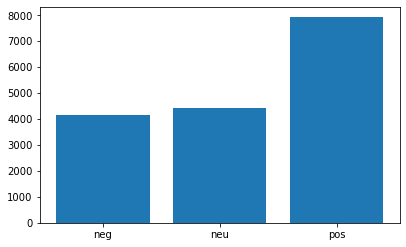

In [66]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
score_label = ["neg", "neu", "pos"]
value = [scores["neg"], scores["neu"], scores["pos"]]
ax.bar(score_label, value)
plt.show()

In [67]:
df.head()

,score,comms_num,timestamp,original_text,text,length,GME,AMC,BB,NOK,TSLA,neg,neu,pos,compound
0,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...,1335,1,0,0,0,0,0.072,0.801,0.127,0.8260
1,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware,80,0,1,0,0,0,0.306,0.694,0.000,-0.2960
2,200,161,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...,currently holding amc nok retarded think move ...,95,1,1,0,1,0,0.316,0.684,0.000,-0.5719
3,222,70,2021-01-28 21:18:25,"We need to keep this movement going, we all ca...",need keep movement going make history believe ...,786,0,1,0,0,0,0.135,0.613,0.252,0.8271
4,562,97,2021-01-28 21:17:28,GME Premarket 🍁 Musk approved 🎮🛑💎✋,gme premarket musk approved,35,1,0,0,0,0,0.000,0.517,0.483,0.4215


In [68]:
new_words = {
'citron': -4.0,  
'hidenburg': -4.0,
'green': 2.0,
'hot': 2.0,
'squeeze': 2.0,
'ape': 2.0,
'apes': 2.0,
'apes together strong': 3.0,
'roaring kitty': 2.0,
'bull': 4.0,
'bullish': 4.0,
'bear': -4.0,
'bearish': 4.0,
'bag holder': -3.0,
'bagholder': -3.0,
'bag holding': -3.0,
'bagholding': -3.0,
'hold': 2.0,
'hold the line': 3.0,
'diamond': 3.0,
'diamond hands': 3.0,
'paper hands': -3.0,
'weak hands': -3.0,
'DD': 2.0,
'double Down': 2.0,
'due diligence': 2.0,
'pump': -2.0,
'pumping': -2.0,
'dump': -2.0,
'pump and dump': -3.0,
'stonk': 2.0,
'stonks': 2.0,
'tendie' : 2.0,
'tendies': 3.0,
'YOLO': 2.0,
'moon': 3.0,
'mooning': 3.0,
'to the moon': 4.0,
'long': 2.0,
'short': -2.0,
'call': 4.0,
'calls': 4.0,
'put': -4.0,
'puts': -4.0,
'overvalued': -3.0,
'undervalued': 3.0,
'low': -2.0,
'high': 2.0,
'buy': 4.0,
'sell': -4.0,
'buy high sell low': -4.0,
'buy the dip': 3.0,
'drop': -3.0,
'rebound': 3.0,
'green': 2.0,
'rip': -3.0,
'offering': 2.0,
'rocket': 3.0,
'break': 2.0,
'we like the stock': 4.0,
'ATH': 4.0,
'IRS': -2.0,
'SEC': -3.0,
'RH': -2.0,
'robinhood': -2.0,
'IPO': 2.0,
'degenerates': -3.0,
'Stimmy': 1.5,
'checks' : 1.0,
'stimmy checks': 2.0,
'loss': -3.0,
'loss porn': -4.0,
'gain': 3.0,
'gain porn': 3.0,
'whale' : -1.0,
'HODL' : 3.0,
'autist': 2.0,
'gamestonk': 2.0,
'crayons': 2.0,
'I eat crayons': 2.0,
'boyfriend': 1.0,
'FOMO': -2.0,
'hedge': -2.0,
'hedgies': -2.0,
'hedge funds': -3.0,
'retard': 2.0,
'retards': 3.0
}

In [69]:
sia.lexicon.update(new_words)

In [70]:
df["neg_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [71]:
scores = {"neg_":0, "neu_":0, "pos_":0}

for i in df["compound_"]:
    if i < -0.2:
        scores["neg_"] += 1
    elif i < 0.2:
        scores["neu_"] += 1
    else:
        scores["pos_"] += 1

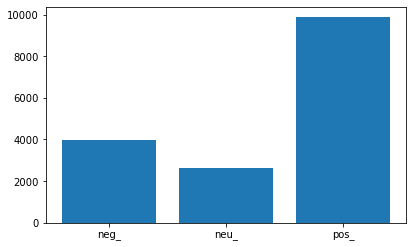

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
score_label = ["neg_", "neu_", "pos_"]
value = [scores["neg_"], scores["neu_"], scores["pos_"]]
ax.bar(score_label, value)
plt.show()

In [73]:
df.head()

,score,comms_num,timestamp,original_text,text,length,GME,AMC,BB,NOK,TSLA,neg,neu,pos,compound,neg_,neu_,pos_,compound_
0,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...,1335,1,0,0,0,0,0.072,0.801,0.127,0.8260,0.069,0.755,0.176,0.9491
1,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware,80,0,1,0,0,0,0.306,0.694,0.000,-0.2960,0.306,0.694,0.000,-0.2960
2,200,161,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...,currently holding amc nok retarded think move ...,95,1,1,0,1,0,0.316,0.684,0.000,-0.5719,0.316,0.684,0.000,-0.5719
3,222,70,2021-01-28 21:18:25,"We need to keep this movement going, we all ca...",need keep movement going make history believe ...,786,0,1,0,0,0,0.135,0.613,0.252,0.8271,0.154,0.534,0.312,0.9287
4,562,97,2021-01-28 21:17:28,GME Premarket 🍁 Musk approved 🎮🛑💎✋,gme premarket musk approved,35,1,0,0,0,0,0.000,0.517,0.483,0.4215,0.000,0.517,0.483,0.4215


In [74]:
##cerate diversity score
def lexical_diversity(my_text_data):
    words = [nltk.word_tokenize(text) for text in my_text_data]
    word_count = len(my_text_data)
    vocab_size = len(set(my_text_data))
    diversity_score = vocab_size / word_count
    return diversity_score

In [75]:
df["lexical_diversity"] = df["text"].apply(lambda x: lexical_diversity(x))

In [76]:
df.head()

,score,comms_num,timestamp,original_text,text,length,GME,AMC,BB,NOK,TSLA,neg,neu,pos,compound,neg_,neu_,pos_,compound_,lexical_diversity
0,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,exit system ceo nasdaq pushed halt trading giv...,1335,1,0,0,0,0,0.072,0.801,0.127,0.8260,0.069,0.755,0.176,0.9491,0.030675
1,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",distract gme thought amc brothers aware,80,0,1,0,0,0,0.306,0.694,0.000,-0.2960,0.306,0.694,0.000,-0.2960,0.410256
2,200,161,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...,currently holding amc nok retarded think move ...,95,1,1,0,1,0,0.316,0.684,0.000,-0.5719,0.316,0.684,0.000,-0.5719,0.327273
3,222,70,2021-01-28 21:18:25,"We need to keep this movement going, we all ca...",need keep movement going make history believe ...,786,0,1,0,0,0,0.135,0.613,0.252,0.8271,0.154,0.534,0.312,0.9287,0.050847
4,562,97,2021-01-28 21:17:28,GME Premarket 🍁 Musk approved 🎮🛑💎✋,gme premarket musk approved,35,1,0,0,0,0,0.000,0.517,0.483,0.4215,0.000,0.517,0.483,0.4215,0.518519


In [77]:
##creating a list of most frequent bigrams
tokens = [nltk.word_tokenize(t) for t in df["text"]]
bgs = nltk.bigrams(list(chain.from_iterable(tokens)))
fdist = nltk.FreqDist(bgs)
most_common=fdist.most_common(10) ## we change it to any other top k
top_words=[word for (word, freq) in most_common]
bigrams = [' '.join(i) for i in top_words]

In [78]:
print(bigrams)

['preview redd', 'auto webp', 'width format', 'png width', 'format png', 'png auto', 'reddit com', 'hedge funds', 'www reddit', 'gme amc']
